# Capacitated Vehicle Routing Problem (CVRP)
## Portfolio Project — Neil H

### Problem Statement
A delivery company based in Cape Town needs to deliver goods to 5 customers 
across the greater Cape Town area, including Stellenbosch. The delivery vehicle 
has a maximum capacity of 40kg. The goal is to find the optimal set of routes 
that minimises total distance travelled while respecting the capacity constraint.

### Approach
This project formulates the problem as a **Capacitated Vehicle Routing Problem (CVRP)** 
and solves it using **Integer Linear Programming** via the PuLP library in Python. 
An interactive map is generated using Folium to visualise the optimal routes.

In [1]:
pip install pulp folium pandas openrouteservice

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pulp
import folium
import pandas as pd
import openrouteservice
print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Define depot and customer locations (latitude, longitude)
locations = {
    'Depot':      (-33.9249, 18.4241),  # Cape Town CBD
    'Customer_1': (-33.9558, 18.4601),  # Claremont
    'Customer_2': (-33.8688, 18.4991),  # Bellville
    'Customer_3': (-33.9089, 18.4103),  # Green Point
    'Customer_4': (-33.9828, 18.4699),  # Tokai
    'Customer_5': (-33.9305, 18.8612),  # Stellenbosch
}

print("Locations defined!")
for name, coords in locations.items():
    print(f"  {name}: {coords}")

Locations defined!
  Depot: (-33.9249, 18.4241)
  Customer_1: (-33.9558, 18.4601)
  Customer_2: (-33.8688, 18.4991)
  Customer_3: (-33.9089, 18.4103)
  Customer_4: (-33.9828, 18.4699)
  Customer_5: (-33.9305, 18.8612)


## Step 1: Define Locations and Calculate Distances
Locations are defined using real GPS coordinates in the Cape Town area. 
The **Haversine formula** is used to calculate the straight-line distance 
between each pair of locations, accounting for the curvature of the Earth.

In [4]:
import math

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371
    
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    return R * c

# Build a distance matrix between all locations
location_names = list(locations.keys())

distance_matrix = {}
for i in location_names:
    for j in location_names:
        if i != j:
            distance_matrix[i, j] = haversine(locations[i], locations[j])

# Print the distances from the Depot to each customer
print("Distances from Depot:")
for name in location_names[1:]:
    print(f"  Depot -> {name}: {distance_matrix['Depot', name]:.2f} km")

Distances from Depot:
  Depot -> Customer_1: 4.78 km
  Depot -> Customer_2: 9.32 km
  Depot -> Customer_3: 2.19 km
  Depot -> Customer_4: 7.70 km
  Depot -> Customer_5: 40.33 km


## Step 2: Formulate the Optimisation Problem
The CVRP is formulated as an **Integer Linear Program (ILP)** with the following components:

- **Decision variables:** Binary variables x[i,j,k] = 1 if vehicle k travels from location i to j
- **Objective:** Minimise total distance travelled across all vehicles
- **Constraints:** Each customer visited exactly once, vehicle capacity not exceeded, 
all routes start and end at the depot, no subtours allowed

In [5]:
# List of all nodes and just the customers
nodes = location_names
customers = location_names[1:]  # Everyone except the depot

# Create the LP problem - we want to MINIMIZE total distance
prob = pulp.LpProblem("Vehicle_Routing", pulp.LpMinimize)

# Decision variables: x[i,j] = 1 if we travel from i to j, 0 otherwise
x = {}
for i in nodes:
    for j in nodes:
        if i != j:
            x[i, j] = pulp.LpVariable(f"x_{i}_{j}", cat='Binary')

# Objective function: minimize total distance travelled
prob += pulp.lpSum(distance_matrix[i, j] * x[i, j] for i in nodes for j in nodes if i != j)

# Constraints: must leave each customer exactly once
for j in customers:
    prob += pulp.lpSum(x[i, j] for i in nodes if i != j) == 1

# Constraints: must arrive at each customer exactly once
for i in customers:
    prob += pulp.lpSum(x[i, j] for j in nodes if i != j) == 1

# Depot: must leave once and return once
prob += pulp.lpSum(x['Depot', j] for j in customers) == 1
prob += pulp.lpSum(x[i, 'Depot'] for i in customers) == 1

print("Problem defined successfully!")
print(f"Number of decision variables: {len(x)}")

Problem defined successfully!
Number of decision variables: 30


In [6]:
# Subtour elimination (Miller-Tucker-Zemlin formulation)
# u[i] represents the order in which customer i is visited
u = {}
for i in customers:
    u[i] = pulp.LpVariable(f"u_{i}", lowBound=1, upBound=len(customers), cat='Continuous')

n = len(customers)
for i in customers:
    for j in customers:
        if i != j:
            prob += u[i] - u[j] + n * x[i, j] <= n - 1

print("Subtour elimination constraints added!")
print("Solving the problem now...")

# Solve it
prob.solve(pulp.PULP_CBC_CMD(msg=0))

print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Total distance: {pulp.value(prob.objective):.2f} km")

Subtour elimination constraints added!
Solving the problem now...
Status: Optimal
Total distance: 90.11 km


In [7]:
# Extract the route from the solution
def get_route(x, nodes):
    route = ['Depot']
    current = 'Depot'
    
    while True:
        for j in nodes:
            if current != j and pulp.value(x[current, j]) == 1:
                route.append(j)
                current = j
                break
        if current == 'Depot':
            break
    
    return route

route = get_route(x, nodes)

print("Optimal Route:")
total = 0
for i in range(len(route) - 1):
    dist = distance_matrix[route[i], route[i+1]]
    total += dist
    print(f"  {route[i]} -> {route[i+1]}: {dist:.2f} km")
print(f"\nTotal distance: {total:.2f} km")

Optimal Route:
  Depot -> Customer_1: 4.78 km
  Customer_1 -> Customer_4: 3.14 km
  Customer_4 -> Customer_5: 36.56 km
  Customer_5 -> Customer_2: 34.12 km
  Customer_2 -> Customer_3: 9.33 km
  Customer_3 -> Depot: 2.19 km

Total distance: 90.11 km


In [8]:
# Create a map centered on Cape Town
m = folium.Map(location=[-33.93, 18.55], zoom_start=11)

# Add markers for each location
colors = {'Depot': 'red', 'Customer_1': 'blue', 'Customer_2': 'blue',
          'Customer_3': 'blue', 'Customer_4': 'blue', 'Customer_5': 'blue'}

for name, coords in locations.items():
    folium.Marker(
        location=coords,
        popup=name,
        tooltip=name,
        icon=folium.Icon(color=colors[name], icon='info-sign')
    ).add_to(m)

# Draw the route as lines
for i in range(len(route) - 1):
    start = locations[route[i]]
    end = locations[route[i+1]]
    folium.PolyLine(
        locations=[start, end],
        color='green',
        weight=3,
        opacity=0.8,
        tooltip=f"{route[i]} → {route[i+1]}"
    ).add_to(m)

# Save the map
m.save('delivery_route.html')
print("Map saved! Open delivery_route.html to view it.")

Map saved! Open delivery_route.html to view it.


In [9]:
import os
print(os.getcwd())

C:\Users\neilh\Delivery Route Optimisation Project


In [10]:
# Add demand (kg) for each customer
demand = {
    'Customer_1': 10,
    'Customer_2': 15,
    'Customer_3': 8,
    'Customer_4': 20,
    'Customer_5': 12,
}

# Vehicle capacity in kg
vehicle_capacity = 40

total_demand = sum(demand.values())
print(f"Total demand: {total_demand} kg")
print(f"Vehicle capacity: {vehicle_capacity} kg")
print(f"Minimum vehicles needed: {math.ceil(total_demand / vehicle_capacity)}")

Total demand: 65 kg
Vehicle capacity: 40 kg
Minimum vehicles needed: 2


In [11]:
num_vehicles = 2
vehicles = list(range(num_vehicles))

# New LP problem
cvrp = pulp.LpProblem("CVRP", pulp.LpMinimize)

# Decision variables: x[i,j,k] = 1 if vehicle k travels from i to j
x = {}
for k in vehicles:
    for i in nodes:
        for j in nodes:
            if i != j:
                x[i, j, k] = pulp.LpVariable(f"x_{i}_{j}_{k}", cat='Binary')

# Objective: minimize total distance across all vehicles
cvrp += pulp.lpSum(
    distance_matrix[i, j] * x[i, j, k]
    for k in vehicles
    for i in nodes
    for j in nodes
    if i != j
)

# Each customer must be visited exactly once across all vehicles
for j in customers:
    cvrp += pulp.lpSum(x[i, j, k] for k in vehicles for i in nodes if i != j) == 1

# Flow conservation: if a vehicle enters a customer it must leave
for k in vehicles:
    for h in customers:
        cvrp += (pulp.lpSum(x[i, h, k] for i in nodes if i != h) ==
                 pulp.lpSum(x[h, j, k] for j in nodes if j != h))

# Each vehicle starts and ends at depot
for k in vehicles:
    cvrp += pulp.lpSum(x['Depot', j, k] for j in customers) <= 1
    cvrp += pulp.lpSum(x[i, 'Depot', k] for i in customers) <= 1

# Capacity constraints
for k in vehicles:
    cvrp += pulp.lpSum(
        demand[j] * x[i, j, k]
        for i in nodes
        for j in customers
        if i != j
    ) <= vehicle_capacity

print("CVRP problem defined!")
print(f"Number of decision variables: {len(x)}")

CVRP problem defined!
Number of decision variables: 60


In [12]:
# Subtour elimination for each vehicle
u = {}
for k in vehicles:
    for i in customers:
        u[i, k] = pulp.LpVariable(f"u_{i}_{k}", lowBound=1, upBound=len(customers), cat='Continuous')

n = len(customers)
for k in vehicles:
    for i in customers:
        for j in customers:
            if i != j:
                cvrp += u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1

print("Subtour elimination added, solving now...")

cvrp.solve(pulp.PULP_CBC_CMD(msg=0))

print(f"Status: {pulp.LpStatus[cvrp.status]}")
print(f"Total distance: {pulp.value(cvrp.objective):.2f} km")

Subtour elimination added, solving now...
Status: Optimal
Total distance: 101.58 km


In [13]:
# Extract routes for each vehicle
def get_vehicle_route(x, nodes, vehicle):
    # Check if this vehicle is used
    if not any(pulp.value(x.get(('Depot', j, vehicle), 0)) == 1 for j in customers):
        return []
    
    route = ['Depot']
    current = 'Depot'
    
    while True:
        moved = False
        for j in nodes:
            if current != j and pulp.value(x.get((current, j, vehicle), 0)) == 1:
                route.append(j)
                current = j
                moved = True
                break
        if not moved or current == 'Depot':
            break
    
    return route

print("Routes per vehicle:\n")
for k in vehicles:
    route_k = get_vehicle_route(x, nodes, k)
    if route_k:
        total_dist = sum(distance_matrix[route_k[i], route_k[i+1]] for i in range(len(route_k)-1))
        total_load = sum(demand[stop] for stop in route_k if stop != 'Depot')
        print(f"Vehicle {k+1}:")
        print(f"  Route: {' -> '.join(route_k)}")
        print(f"  Total distance: {total_dist:.2f} km")
        print(f"  Total load: {total_load} kg / {vehicle_capacity} kg")
        print()

Routes per vehicle:

Vehicle 1:
  Route: Depot -> Customer_5 -> Customer_2 -> Customer_3 -> Depot
  Total distance: 85.97 km
  Total load: 35 kg / 40 kg

Vehicle 2:
  Route: Depot -> Customer_4 -> Customer_1 -> Depot
  Total distance: 15.61 km
  Total load: 30 kg / 40 kg



## Step 3: Results
The solver finds the globally optimal solution. Routes are extracted and 
visualised on an interactive map — blue route for Vehicle 1, red for Vehicle 2.

In [14]:
# Create map
m2 = folium.Map(location=[-33.93, 18.55], zoom_start=11)

# Colours for each vehicle
vehicle_colors = ['blue', 'red']

# Draw routes for each vehicle
for k in vehicles:
    route_k = get_vehicle_route(x, nodes, k)
    if route_k:
        for i in range(len(route_k) - 1):
            start = locations[route_k[i]]
            end = locations[route_k[i+1]]
            folium.PolyLine(
                locations=[start, end],
                color=vehicle_colors[k],
                weight=4,
                opacity=0.8,
                tooltip=f"Vehicle {k+1}: {route_k[i]} → {route_k[i+1]}"
            ).add_to(m2)

# Add markers for each location
for name, coords in locations.items():
    if name == 'Depot':
        folium.Marker(
            location=coords,
            popup='Depot',
            tooltip='Depot',
            icon=folium.Icon(color='green', icon='home')
        ).add_to(m2)
    else:
        folium.Marker(
            location=coords,
            popup=f"{name} | Demand: {demand[name]}kg",
            tooltip=name,
            icon=folium.Icon(color='gray', icon='shopping-cart')
        ).add_to(m2)

m2.save('cvrp_route.html')
print("Map saved! Open cvrp_route.html to view it.")

Map saved! Open cvrp_route.html to view it.


In [15]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


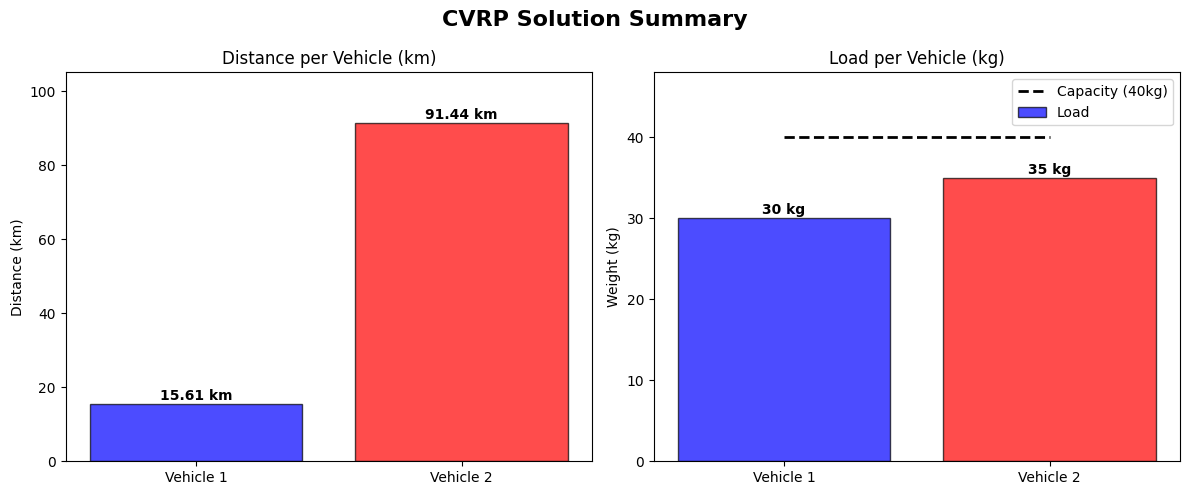

Summary chart saved!


In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('CVRP Solution Summary', fontsize=16, fontweight='bold')

# Chart 1: Distance per vehicle
vehicle_labels = ['Vehicle 1', 'Vehicle 2']
distances = [15.61, 91.44]
bar_colors = ['blue', 'red']

axes[0].bar(vehicle_labels, distances, color=bar_colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Distance per Vehicle (km)')
axes[0].set_ylabel('Distance (km)')
for i, v in enumerate(distances):
    axes[0].text(i, v + 1, f'{v} km', ha='center', fontweight='bold')
axes[0].set_ylim(0, max(distances) * 1.15)

# Chart 2: Load per vehicle as a bar vs capacity
loads = [30, 35]
capacity_line = [vehicle_capacity, vehicle_capacity]

axes[1].bar(vehicle_labels, loads, color=bar_colors, alpha=0.7, edgecolor='black', label='Load')
axes[1].plot(vehicle_labels, capacity_line, 'k--', linewidth=2, label=f'Capacity ({vehicle_capacity}kg)')
axes[1].set_title('Load per Vehicle (kg)')
axes[1].set_ylabel('Weight (kg)')
for i, v in enumerate(loads):
    axes[1].text(i, v + 0.5, f'{v} kg', ha='center', fontweight='bold')
axes[1].set_ylim(0, vehicle_capacity * 1.2)
axes[1].legend()

plt.tight_layout()
plt.savefig('cvrp_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Summary chart saved!")

In [17]:
client = openrouteservice.Client(key='eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6ImVjNzRhNmQwODNkYjQ5Nzk5YmI4YTQxZDkwY2Q4MjQ4IiwiaCI6Im11cm11cjY0In0=')

# Test it works
print("Testing API connection...")
test = client.directions(
    coordinates=[[18.4241, -33.9249], [18.4601, -33.9558]],
    profile='driving-car'
)
print("API connection successful!")

Testing API connection...
API connection successful!


In [18]:
def get_road_route(client, coord1, coord2):
    # ORS uses [longitude, latitude] order (opposite to folium!)
    result = client.directions(
        coordinates=[[coord1[1], coord1[0]], [coord2[1], coord2[0]]],
        profile='driving-car',
        format='geojson'
    )
    # Extract the route coordinates
    route_coords = result['features'][0]['geometry']['coordinates']
    # Convert back to [latitude, longitude] for folium
    return [[coord[1], coord[0]] for coord in route_coords]

print("Road routing function defined!")

Road routing function defined!


In [19]:
# Create new map with road routes
m3 = folium.Map(location=[-33.93, 18.55], zoom_start=11)

vehicle_colors = ['blue', 'red']

print("Fetching road routes...")

for k in vehicles:
    route_k = get_vehicle_route(x, nodes, k)
    if route_k:
        for i in range(len(route_k) - 1):
            start = locations[route_k[i]]
            end = locations[route_k[i+1]]
            
            # Get actual road route
            road_coords = get_road_route(client, start, end)
            
            folium.PolyLine(
                locations=road_coords,
                color=vehicle_colors[k],
                weight=4,
                opacity=0.8,
                tooltip=f"Vehicle {k+1}: {route_k[i]} → {route_k[i+1]}"
            ).add_to(m3)
            
            print(f"  Vehicle {k+1}: {route_k[i]} → {route_k[i+1]} ✓")

# Add markers
for name, coords in locations.items():
    if name == 'Depot':
        folium.Marker(
            location=coords,
            popup='Depot',
            tooltip='Depot',
            icon=folium.Icon(color='green', icon='home')
        ).add_to(m3)
    else:
        folium.Marker(
            location=coords,
            popup=f"{name} | Demand: {demand[name]}kg",
            tooltip=name,
            icon=folium.Icon(color='gray', icon='shopping-cart')
        ).add_to(m3)

m3.save('cvrp_road_route.html')
print("\nMap saved! Open cvrp_road_route.html to view it.")

Fetching road routes...
  Vehicle 1: Depot → Customer_5 ✓
  Vehicle 1: Customer_5 → Customer_2 ✓
  Vehicle 1: Customer_2 → Customer_3 ✓
  Vehicle 1: Customer_3 → Depot ✓
  Vehicle 2: Depot → Customer_4 ✓
  Vehicle 2: Customer_4 → Customer_1 ✓
  Vehicle 2: Customer_1 → Depot ✓

Map saved! Open cvrp_road_route.html to view it.
